# Explore the data

## Import libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [105]:
import json
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import regex as re
from tqdm import tqdm

## Load the data

In [3]:
with open('product_categories.txt', 'r') as categories_fh:
    categories = [category.strip() for category in categories_fh.readlines()]
    
with open('product_data.json', 'r') as data_fh:
    data = pd.DataFrame(json.load(data_fh))

print(f"Number of categories = {len(categories)}")
print()
for category in categories:
    print(category)
    
print()    
print(f"Number of products = {len(data)}")

small_sample = data.sample(10)
large_sample = data.sample(100)


display(small_sample)

Number of categories = 11

Dresses
Tops
Jeans
Skirts
Rompers
Shoes
Bags
Jewelry
Swimwear
Intimates
Others

Number of products = 1000


,description,id,image_path,images_url
640,"Words to dress by, when you want to get a head...",640,images/640.jpg,https://www.jcrew.com/s7-img-facade/J4114_RD58...
242,"Everybody loves a flattering wrap top, so we m...",242,images/242.jpg,https://www.jcrew.com/s7-img-facade/J2842_KA28...
277,Shop the Women's Collection Petite Leather Leg...,277,images/277.jpg,https://www.jcrew.com/s7-img-facade/E4819_BK00...
926,"Our DD and DDD cup crew, this one's for you! T...",926,None,http://cdn.shopify.com/s/files/1/1115/6560/pro...
863,<ul>\n<li>100% Cotton</li>\n<li>Made in Mexico...,863,images/863.jpg,//cdn.shopify.com/s/files/1/0075/7652/products...
611,"Topped with an allover print, this cushion is ...",611,images/611.jpg,//euimages.urbanoutfitters.com/is/image/UrbanO...
361,Shop the Women's High-Rise Cameron Pant In Fou...,361,images/361.jpg,https://www.jcrew.com/s7-img-facade/H6573_BL81...
161,Shop the Women's Bermuda Short In Stretch Line...,161,images/161.jpg,https://www.jcrew.com/s7-img-facade/H7750_WT00...
367,"In dieser strukturierten, glasierten Keramikva...",367,images/367.jpg,//euimages.urbanoutfitters.com/is/image/UrbanO...
883,Shop the Tall Paley Pant In Super 120S Wool at...,883,images/883.jpg,https://www.jcrew.com/s7-img-facade/52331_GY64...


## Explore text data

### How many descriptions have an exact word match with the category

In [4]:
def exact_match(desc):
    ret = []
    for category in categories:
        if category.lower() in desc.lower():
            ret.append(category)
    return ret

data['exact_match'] = data.description.apply(exact_match)
num_at_least_one_matches = data.exact_match.apply(lambda x: len(x) > 0).sum()

print(f"{num_at_least_one_matches} of the descriptions had an exact match with at least one of the categories.")

num_more_than_one = data.exact_match.apply(lambda x: len(x) > 1).sum()

print(f"{num_more_than_one} of the descriptions had an exact match with more than one of the categories.")

print()
print("The descriptions with more than one exact match are:")
print()
for desc in data[data.exact_match.apply(lambda x: len(x) > 1)].description:
    print(desc)
    print()

214 of the descriptions had an exact match with at least one of the categories.
2 of the descriptions had an exact match with more than one of the categories.

The descriptions with more than one exact match are:

In terms of hands-down closet essentials, our boy shirt ranks up there with blue jeans, chinos and little black dresses. Featuring a boyfriend-inspired fit that's tailored especially for you, this one sports a fun, confetti-inspired plaid we love. Body length: 27 1/4. Cotton/elastane. Machine wash. Import. Online only.

In terms of hands-down closet essentials, our boy shirt ranks up there with blue jeans, chinos and little black dresses. Featuring a boyfriend-inspired fit that's tailored especially for you, we made this one in a crisp cotton, with embroidered and embellished details we just love. Body length: 27 1/4. Cotton. Tab sleeves. Functional buttons at cuffs. Button placket. Hand wash. Import. Online only.



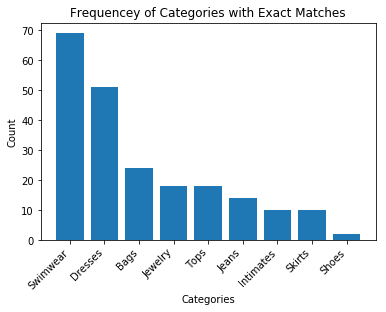

In [5]:
matches = Counter()
for match in data.exact_match:
    matches += Counter(match)
sorted_matches = matches.most_common()

plt.bar([key for key, val in sorted_matches], [val for key, val in sorted_matches])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Frequencey of Categories with Exact Matches')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
print()

### Iterate with regexes and data

For our baseline we can use the exact matches. It looks like we might be able to do a little better though. Maybe if we can find regex aliases for categories like "Footwear" for "Shoes" we might be able to get better results.

In [6]:
aliases = {
    'Dresses': [r'\bdress'],
    'Tops': [r'\btop', r'shirt', r'tank', r'\bsweater', 
             r'\bcardigan', r'\bpullover', r'\bturtleneck', 
             r'\btee', r'\bhoodie'],
    'Jeans': [r'\bjean'],
    'Skirts': [r'\bskirt'],
    'Rompers': [r'\bromper'],
    'Shoes': [r'\bshoe', r'\bfootwear', r'\bsandals', r'\bflat', r'\bheel', r'\bboot'],
    'Bags': [r'\bbag', r'\bpurse'],
    'Jewelry': [r'\bjewelry', r'\bnecklace', r'\bring', r'\bbracelet', r'\bchain', r'\bearring'],
    'Swimwear': [r'\bswim', r'\bbikini'],
    'Intimates': [r'\bintimate', r'\bbra(ssiere|lette)?\b', r'\bboxer', r'\bunderwear', r'\bundie', r'\bknicker'],
    'Others': []
}

neg_aliases = {
    'Dresses': [r'\bdressy'],
    'Tops': [],
    'Jeans': [],
    'Skirts': [],
    'Rompers': [],
    'Shoes': [],
    'Bags': [],
    'Jewelry': [],
    'Swimwear': [],
    'Intimates': [],
    'Others': []
}
for category in aliases:
    aliases[category] = re.compile(r'|'.join(aliases[category]), re.IGNORECASE)
    if len(neg_aliases[category]) > 0:
        neg_aliases[category] = re.compile(r'|'.join(neg_aliases[category]), re.IGNORECASE)    

In [8]:
def regex_match(desc):
    """Return a sorted list of matched categories based on the first matched category"""
    ret_list = []
    for category, regex in aliases.items():
        if category == "Others":
            continue
        if neg_aliases[category] != [] and neg_aliases[category].search(desc):
            continue
        search = regex.search(desc)
        if search is not None:
            ret_list.append((category, search.span()))
    return [category for category, _ in sorted(ret_list, key=lambda x: x[1][0])]

data['regex_match'] = data.description.apply(regex_match)

num_at_least_one_matches = data.regex_match.apply(lambda x: len(x) > 0).sum()

print(f"{num_at_least_one_matches} description matches.")

657 description matches.


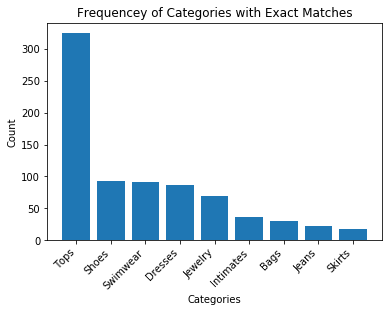

In [9]:
matches = Counter()
for match in data.regex_match:
    matches += Counter(match)
sorted_matches = matches.most_common()

plt.bar([key for key, val in sorted_matches], [val for key, val in sorted_matches])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Frequencey of Categories with Exact Matches')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
print()

In [10]:
data.sample(frac=1.0).to_csv('regex_matches.csv', index=False, encoding='utf-8-sig')

## Explore Image Data

In [11]:
from fastai import *
from fastai.vision import *

In [27]:
filtered_data = data[data.image_path.apply(lambda x: x is not None)]

In [28]:
imgdata = ImageDataBunch.from_lists(
    '.',
    fnames=filtered_data.image_path,
    labels=filtered_data.regex_match.apply(lambda x: 'Other' if x == [] else x[0]),
    ds_tfms=get_transforms(),
    size=224,
    num_workers=0
)

imgdata.normalize(imagenet_stats)

print(imgdata.classes)
len(imgdata.classes), imgdata.c

['Bags', 'Dresses', 'Intimates', 'Jeans', 'Jewelry', 'Other', 'Shoes', 'Skirts', 'Swimwear', 'Tops']


(10, 10)

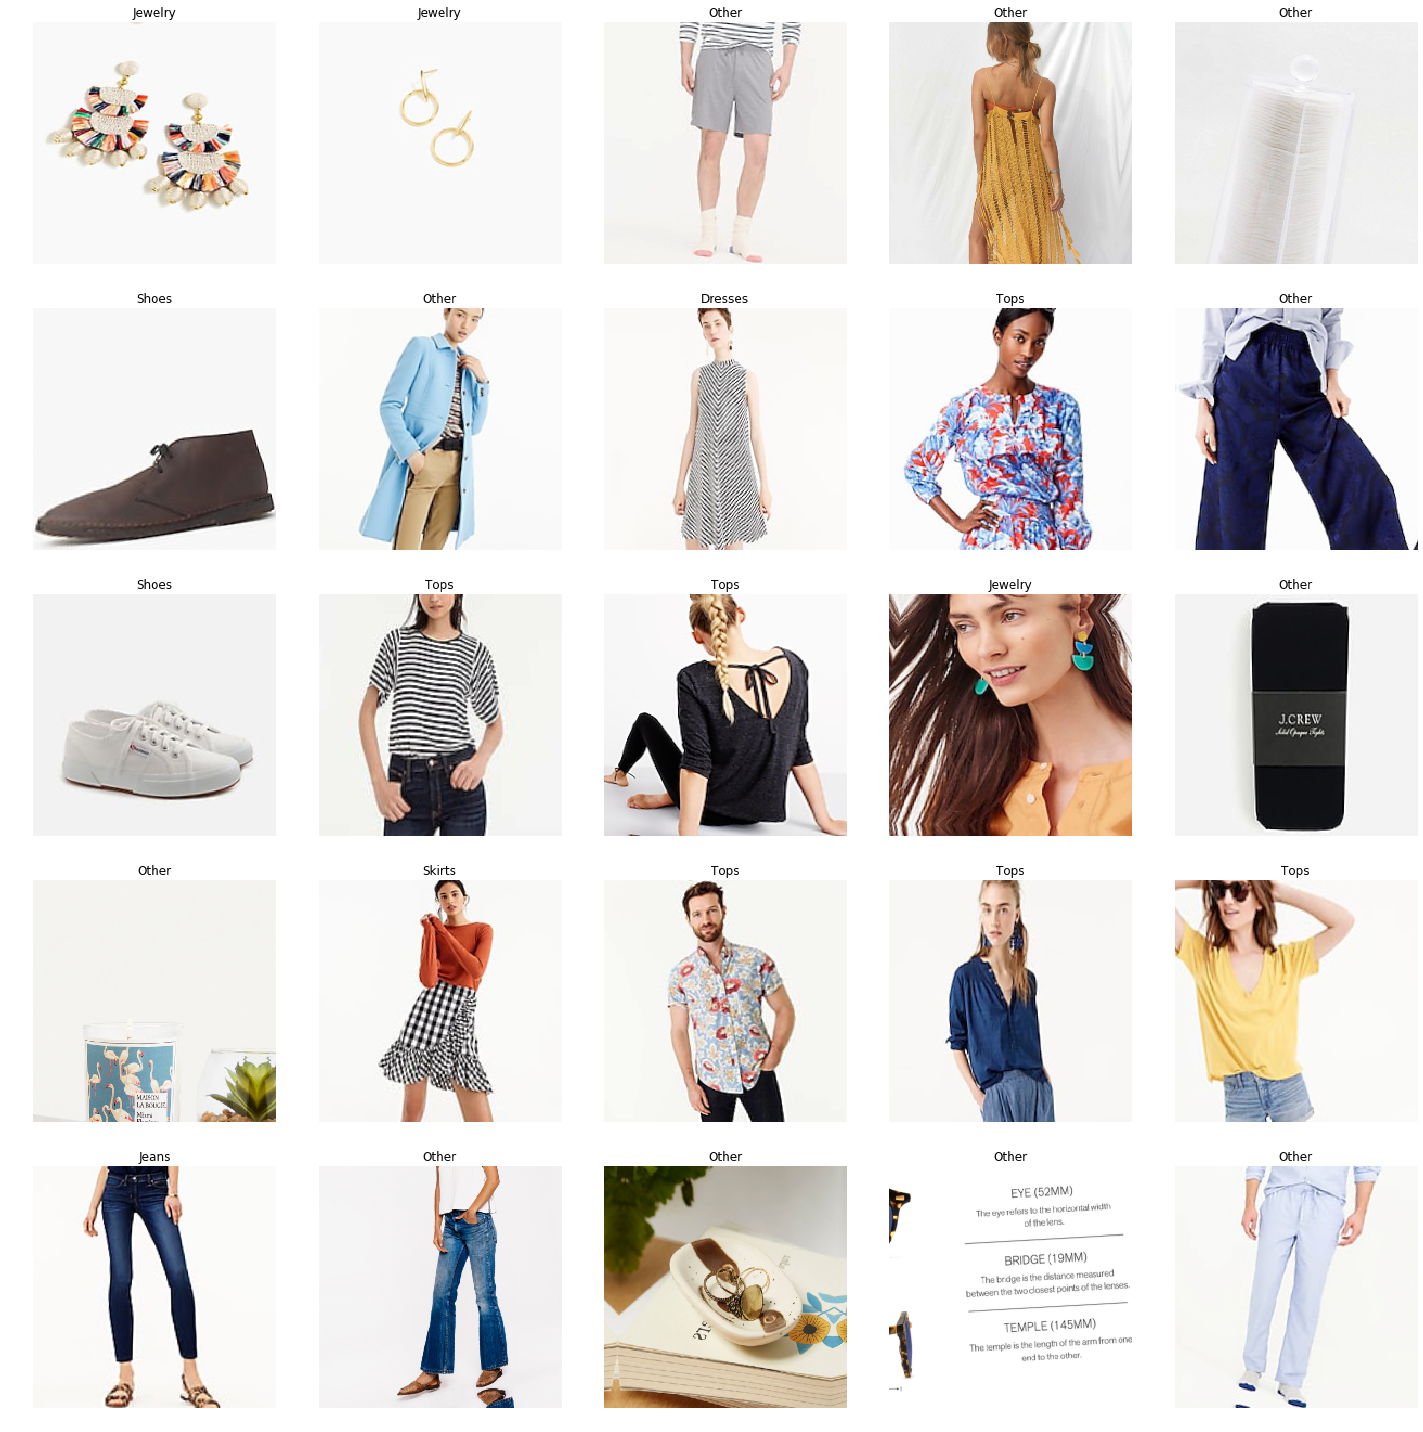

In [29]:
imgdata.show_batch()

In [30]:
learn = cnn_learner(imgdata, models.resnet34, metrics=error_rate)

In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.522600,1.671842,0.481675,07:35
1,1.945070,1.569062,0.387435,08:08
2,1.577590,1.407764,0.350785,07:17
3,1.362805,1.383196,0.345550,06:12


In [49]:
learn.save('stage-1')
learn.export('trained_model.pkl')

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

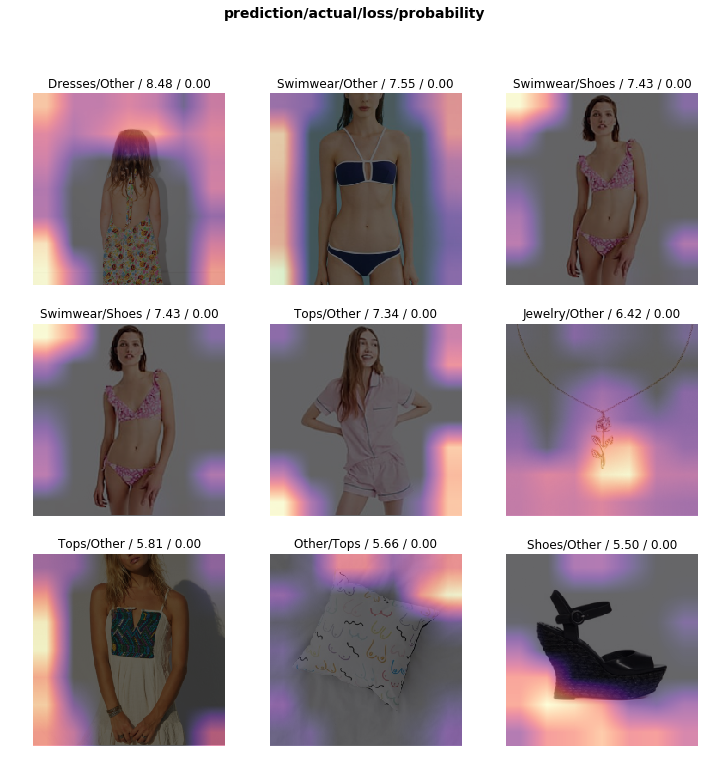

In [34]:
interp.plot_top_losses(9)

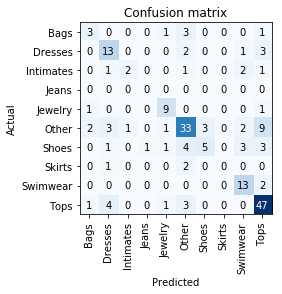

In [35]:
interp.plot_confusion_matrix()

In [36]:
interp.most_confused()

[('Other', 'Tops', 9),
 ('Shoes', 'Other', 4),
 ('Tops', 'Dresses', 4),
 ('Bags', 'Other', 3),
 ('Dresses', 'Tops', 3),
 ('Other', 'Dresses', 3),
 ('Other', 'Shoes', 3),
 ('Shoes', 'Swimwear', 3),
 ('Shoes', 'Tops', 3),
 ('Tops', 'Other', 3),
 ('Dresses', 'Other', 2),
 ('Intimates', 'Swimwear', 2),
 ('Other', 'Bags', 2),
 ('Other', 'Swimwear', 2),
 ('Skirts', 'Other', 2),
 ('Swimwear', 'Tops', 2),
 ('Bags', 'Jewelry', 1),
 ('Bags', 'Tops', 1),
 ('Dresses', 'Swimwear', 1),
 ('Intimates', 'Dresses', 1),
 ('Intimates', 'Other', 1),
 ('Intimates', 'Tops', 1),
 ('Jewelry', 'Bags', 1),
 ('Jewelry', 'Tops', 1),
 ('Other', 'Intimates', 1),
 ('Other', 'Jewelry', 1),
 ('Shoes', 'Dresses', 1),
 ('Shoes', 'Jeans', 1),
 ('Shoes', 'Jewelry', 1),
 ('Skirts', 'Dresses', 1),
 ('Tops', 'Bags', 1),
 ('Tops', 'Jewelry', 1)]

### Predict categories using trained model

In [126]:
def get_preds(image_path):
    return learn.predict(open_image(image_path))[2].numpy()

preds = []
for image_path in tqdm(data.image_path):
    if image_path is None:
        preds.append(None)
    else:
        preds.append(get_preds(image_path))
        
data = data.assign(preds = preds)

100%|██████████| 1000/1000 [04:10<00:00,  3.99it/s]


In [141]:
categories = learn.data.classes
def get_top_categories(preds):
    if preds is None:
        return None
    return [categories[index] for index in np.argsort(preds)[::-1]]

data = data.assign(sorted_categories=data.preds.apply(get_top_categories))

In [146]:
data.head()

,description,id,image_path,images_url,exact_match,regex_match,preds,sorted_categories
0,Supersoft speckled French terry makes this (tu...,0,images/0.jpg,https://www.jcrew.com/s7-img-facade/H3588_PK63...,[],[Tops],"[0.00074634206, 0.012208741, 0.0012927569, 0.0...","[Tops, Dresses, Skirts, Intimates, Swimwear, J..."
1,Consider this embroidered layer your new dress...,1,images/1.jpg,https://www.jcrew.com/s7-img-facade/H2092_BL81...,[],[Tops],"[0.004208789, 0.0394759, 0.0079264585, 0.00511...","[Tops, Dresses, Skirts, Intimates, Jeans, Bags..."
2,Shop the Men's Slim American Pima Cotton Oxfor...,2,images/2.jpg,https://www.jcrew.com/s7-img-facade/H4702_WX05...,[],[Tops],"[0.001356294, 0.00068930537, 0.0029273957, 0.0...","[Tops, Other, Jeans, Intimates, Skirts, Shoes,..."
3,Shop the Women's Off-The-Shoulder Foldover Top...,3,images/3.jpg,https://www.jcrew.com/s7-img-facade/H6682_BK00...,[],[Tops],"[0.011185976, 0.098297566, 0.011324089, 0.0028...","[Tops, Dresses, Skirts, Swimwear, Shoes, Intim..."
4,Shop the Women's Ruffle Plunge V-Neck One-Piec...,4,images/4.jpg,https://www.jcrew.com/s7-img-facade/J4506_BL58...,[Swimwear],[Swimwear],"[0.018960686, 0.06301837, 0.08731399, 0.012463...","[Swimwear, Intimates, Dresses, Tops, Bags, Jew..."


In [148]:
final_predictions = []
for _, row in data.iterrows():
    final_pred = None
    if row.regex_match == []:
        if row.sorted_categories is None:
            final_pred = 'Other'
        else:
            final_pred = row.sorted_categories[0]
    else:
        if row.sorted_categories is None:
            final_pred = row.regex_match[0]
        else:
            # Select the first category that matches a regex_match
            for category in row.sorted_categories:
                if category in row.regex_match:
                    final_pred = category
                    break
    final_predictions.append({
        'description': row.description,
        'images_url': row.images_url,
        'prediction': 'Others' if final_pred == 'Other' else final_pred # A mistake made earlier on
    })

with open('final_predictions.json', 'w') as fh:
    json.dump(final_predictions, fh)